In [1]:
import pickle
import torch
import torch.nn as nn

import torchvision
from torchvision import datasets

import numpy as np
from collections import Counter

# from networkx.classes.function import neighbors
import sys
from tqdm import tqdm

from src import *

In [2]:
plt.style.use('fivethirtyeight')

In [3]:
datasetMNIST = datasets.MNIST(root="./", download=True)

## Decentralized-SGD
Mimicking an actual decentralized-sgd process (without multiple workers)

In [4]:
load = Loader()
mnist, mnistL = load.toArray(datasetMNIST)
# mnist, mnistL = (torch.tensor(mnist).float()[:30000], torch.tensor(mnistL))[:30000]
mnist, mnistL = (torch.tensor(mnist).float(), torch.tensor(mnistL))
print('shape of dataset from MNIST {}'.format(mnist.shape))

shape of dataset from MNIST torch.Size([60000, 28, 28])


In [5]:
trainData, trainL= mnist[:-20000], mnistL[:-20000]
valData , valL   = mnist[-20000:-10000], mnistL[-20000:-10000]
testData, testL  = mnist[-10000:], mnistL[-10000:]

Check label are balanced in train/val/test

Text(0.5, 1.0, 'test label distribution')

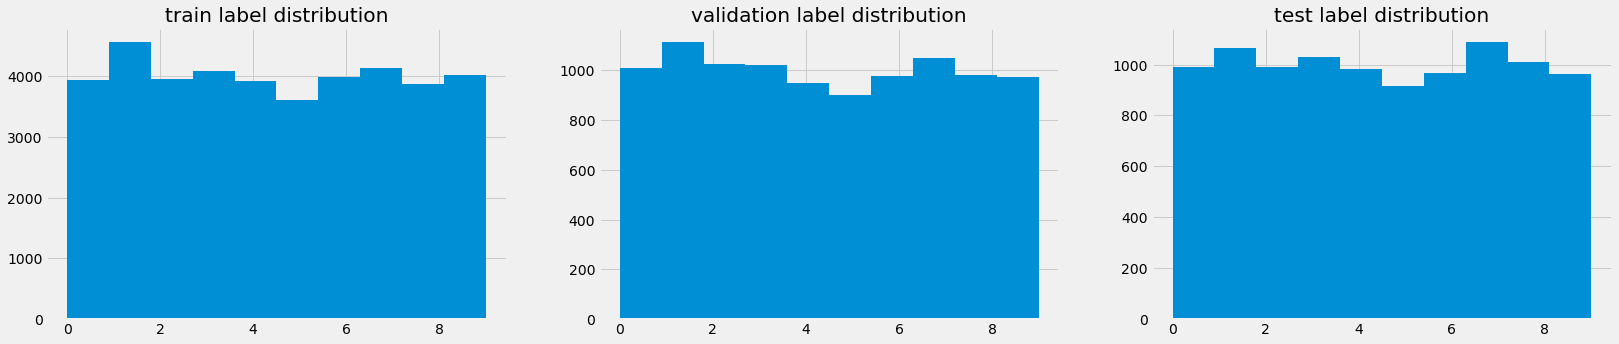

In [6]:
fig,ax = plt.subplots(1,3,figsize=(25,5))
ax[0].hist(trainL.flatten())
ax[1].hist(valL.flatten())
ax[2].hist(testL.flatten())
ax[0].set_title("train label distribution")
ax[1].set_title("validation label distribution")
ax[2].set_title("test label distribution")

In [7]:
def dataDistrib(dataset, K):
    for k in range(K):
        print("node {}: {}".format(k,Counter(np.array(dataset[k][1].flatten()))))    

### Standard Topology (static)
We check standard topologies applied on non-iid. We could pick from these topologies those that behave best for the label-skew distribution we use.

In [12]:
scoresTrain  = []
scoresVal    = []
scoresTest   = []

# PARAM DEFINING 
K = 8 # number of nodes
nbEpoch    = 1000 # we use 100 epochs for the heuristic algorithm with 10 diff topology, for fairness -> 1000
batchSize  = 100
nodesValidation = (valData.reshape(-1, valData.shape[0], 1, 28, 28), valL.reshape(-1,valL.shape[0]))
nodesTest       = (testData.reshape(-1, testData.shape[0], 1, 28, 28), testL.reshape(-1,testL.shape[0]))
startingTopology= ringTopology


# LOOP FOR STATIC TOPOLOGY
for s in tqdm(range(5)):
    # Generating NON-IID Dataset distribution
    nodesNoneIIDData = []
    np.random.seed(s)
    indexIID = mnist_noniid(trainData, trainL, K)

    for i in range(K):
        tmpX = mnist[indexIID[i]].reshape(-1, batchSize, 1, 28,28)
        tmpy = mnistL[indexIID[i]].reshape(-1, batchSize)
        nodesNoneIIDData.append((tmpX,tmpy))

    # Reset topology that we improve
    topology = startingTopology(K)

    resultsTrain = []
    resultsVal   = []
    resultsModel = []
    
    resultdfTrain, resultdfVal, _, models = computeDecentralize(nodesNoneIIDData, topology, 
                                                        K, max_epoch=nbEpoch,
                                                       validation=nodesValidation)
    resultsTrain.append(resultdfTrain)
    resultsVal.append(resultdfVal)
    resultsModel.append(models)

    # Test accuracy with obtained model
    loss_fn = nn.CrossEntropyLoss()
    ret   = []
    graph = topology.to_networkx()

    test_stats = {str(node):[] for node in graph.nodes()}
    for node_idx in graph.nodes():

        lossTest, accTest = subopt(nodesTest, models[node_idx], loss_fn)
        curTestDir        = {'loss': lossTest, 'acc': accTest}
        test_stats[str(node_idx)].append(curTestDir)

    resultdfTest = getLogs(test_stats)
    ret.append(resultdfTest)

    # LOGGING THE RESULTS
    scoresTrain.append(resultsTrain)
    scoresVal.append(resultsVal)
    scoresTest.append(ret)

In [28]:
# # LOGGING THE RESULTS OF EXPERIMENTS

# with open('./logs/scoresTrainStandard.pkl','wb') as f:
#     pickle.dump(scoresTrain,f)
# with open('./logs/scoresValStandard.pkl','wb') as f:
#     pickle.dump(scoresVal,f)
# with open('./logs/scoresTestStandard.pkl','wb') as f:
#     pickle.dump(scoresTest,f)    

### Random Sampling Search Topology
Attempts to see whether a naive random search with sampled topology with fixed number of edges would allow for a potential better performance compared to standard topologies. (Not added in the report but can be tested regardless)

In [ ]:
def randomTopology(seed, nbEdge, K):
    A = sampleAdj(nbEdge,1,K,seed=seed)
    custom = CustomTopology(K)
    custom.set_neighbours(A)
    custom.to_networkx()
    if nx.is_connected(custom.graph):
        return custom

In [ ]:
scoresTrain  = []
scoresVal    = []
scoresTest   = []

# PARAM DEFINING 
K = 8 # number of nodes
nbEpoch    = 1000 # we use 100 epochs for the heuristic algorithm with 10 diff topology, for fairness -> 1000
batchSize  = 100
nodesValidation = (valData.reshape(-1, valData.shape[0], 1, 28, 28), valL.reshape(-1,valL.shape[0]))
nodesTest       = (testData.reshape(-1, testData.shape[0], 1, 28, 28), testL.reshape(-1,testL.shape[0]))
startingTopology= ringTopology


# LOOP FOR STATIC TOPOLOGY
for s in tqdm(range(10)):
    # Generating NON-IID Dataset distribution
    nodesNoneIIDData = []
    np.random.seed(s)
    indexIID = mnist_noniid(trainData, trainL, K)

    for i in range(K):
        tmpX = mnist[indexIID[i]].reshape(-1, batchSize, 1, 28,28)
        tmpy = mnistL[indexIID[i]].reshape(-1, batchSize)
        nodesNoneIIDData.append((tmpX,tmpy))

    # Reset topology that we improve
    topology = startingTopology(K)

    resultsTrain = []
    resultsVal   = []
    resultsModel = []
    
    resultdfTrain, resultdfVal, _, models = computeDecentralize(nodesNoneIIDData, topology, 
                                                        K, max_epoch=nbEpoch,
                                                       validation=nodesValidation)
    resultsTrain.append(resultdfTrain)
    resultsVal.append(resultdfVal)
    resultsModel.append(models)

    # Test accuracy with obtained model
    loss_fn = nn.CrossEntropyLoss()
    ret   = []
    graph = topology.to_networkx()

    test_stats = {str(node):[] for node in graph.nodes()}
    models     = resultsModel[k]
    for node_idx in graph.nodes():

        lossTest, accTest = subopt(nodesTest, models[node_idx], loss_fn)
        curTestDir        = {'loss': lossTest, 'acc': accTest}
        test_stats[str(node_idx)].append(curTestDir)

    resultdfTest = getLogs(test_stats)
    ret.append(resultdfTest)

    # LOGGING THE RESULTS
    scoresTrain.append(resultsTrain)
    scoresVal.append(resultsVal)
    scoresTest.append(ret)

## Iterative Search Topology

Motivated by making the worst node's accuracy better, we add edges to a starting topology.

In [14]:
def standardTopology(K, standardTopo):
    custom = CustomTopology(K)
    A = nx.adjacency_matrix(standardTopo(K).to_networkx()).toarray()
    custom.set_neighbours(A)
    custom.to_networkx()
    return custom

### Main Experiment Loop
We test our algorithm 10 times with different seeds (data distribution) with different training split.
We then compare the accuracy on testset obtained by standard topology versus the iterative improved topology.

In [15]:
scoresTrain  = []
scoresVal    = []
scoresTest   = []


# PARAM DEFINING 
K = 8 # number of nodes
nbEpoch    = 100
batchSize  = 100
nodesValidation = (valData.reshape(-1, valData.shape[0], 1, 28, 28), valL.reshape(-1,valL.shape[0]))
nodesTest       = (testData.reshape(-1, testData.shape[0], 1, 28, 28), testL.reshape(-1,testL.shape[0]))
startingTopology= BinaryTreeTopology


# LOOP FOR HEURISTIC ALGORITHM
for s in range(10):
    # Generating NON-IID Dataset distribution
    nodesNoneIIDData = []
    
    np.random.seed(s)
    torch.manual_seed(s)
    
    indexIID = mnist_noniid(trainData, trainL, K)

    for i in range(K):
        tmpX = mnist[indexIID[i]].reshape(-1, batchSize, 1, 28,28)
        tmpy = mnistL[indexIID[i]].reshape(-1, batchSize)
        nodesNoneIIDData.append((tmpX,tmpy))

    # Reset topology that we improve
    topology = standardTopology(K, startingTopology)

    resultsTrain = []
    resultsVal   = []
    resultsModel = []
    for k in range(10):
        # We train a first iteration the model
        resultdfTrain, resultdfVal, _, models = computeDecentralize(nodesNoneIIDData, topology, 
                                                            K, max_epoch=nbEpoch,
                                                           validation=nodesValidation)
        resultsTrain.append(resultdfTrain)
        resultsVal.append(resultdfVal)
        resultsModel.append(models)  

        # no need to change topology at the last iteration
        if k < 9:        
            nodeMin     = np.argmin(resultdfVal[resultdfVal['Epoch']==nbEpoch]['acc'])
            node2Change = resultdfVal[resultdfVal['Epoch']==nbEpoch].iloc[nodeMin]['node#']

            # Let's find a non neighbour node to add into the neighbours 
            # so as to perhaps have better performance later on
            cur_neighbours = topology.get_neighbors(int(node2Change))
            exist          = set()
            for cur in cur_neighbours:
                exist      = exist.union(set(np.array(nodesNoneIIDData[cur][1].flatten())))

            non_neighbours = list(set(range(K)) - set(cur_neighbours) - set([int(node2Change)]))
            if len(non_neighbours) == 0: break
            idxBest        = np.argmax([len(exist.union(set(np.array(nodesNoneIIDData[noncur][1].flatten())))) 
                               for noncur in non_neighbours])
            node2attach    = non_neighbours[idxBest]

            topology.adjency[int(node2Change),node2attach] = 1
            topology.adjency[node2attach,int(node2Change)] = 1
            topology.to_networkx()

    # Test accuracy with obtained models
    loss_fn = nn.CrossEntropyLoss()
    ret   = []
    graph = topology.to_networkx()
    for k in range(len(resultsModel)):
        test_stats = {str(node):[] for node in graph.nodes()}
        models     = resultsModel[k]
        for node_idx in graph.nodes():

            lossTest, accTest = subopt(nodesTest, models[node_idx], loss_fn)
            curTestDir        = {'loss': lossTest, 'acc': accTest}
            test_stats[str(node_idx)].append(curTestDir)

        resultdfTest = getLogs(test_stats)
        ret.append(resultdfTest)
        
        
    # LOGGING THE RESULTS
    scoresTrain.append(resultsTrain)
    scoresVal.append(resultsVal)
    scoresTest.append(ret)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [16]:
# # LOGGING THE RESULTS OF EXPERIMENTS
# with open('./trainingLogs/scoresTrainImprovedBinary.pkl','wb') as f:
#     pickle.dump(scoresTrain,f)
# with open('./trainingLogs/scoresValImprovedBinary.pkl','wb') as f:
#     pickle.dump(scoresVal,f)
# with open('./trainingLogs/scoresTestImprovedBinary.pkl','wb') as f:
#     pickle.dump(scoresTest,f)    